In [1]:
!pip install networkx


In [2]:
!pip install torch


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-<your_torch_version>+<your_cuda_version>.html


/bin/bash: line 1: your_torch_version: No such file or directory


In [4]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


In [5]:
import torch
import matplotlib.pyplot as plt
import networkx as nx



In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [20]:
from torch_geometric.nn import GCNConv

In [21]:

from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.utils import to_networkx

In [22]:
# Load a sample dataset (e.g., Cora, Citeseer, Pubmed)
dataset = Planetoid(root='/tmp/Cora', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [25]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

In [26]:
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

Epoch 0, Loss: 1.9551, Test Accuracy: 0.3220
Epoch 10, Loss: 0.7771, Test Accuracy: 0.7340
Epoch 20, Loss: 0.2564, Test Accuracy: 0.7800
Epoch 30, Loss: 0.0814, Test Accuracy: 0.7770
Epoch 40, Loss: 0.0572, Test Accuracy: 0.7760
Epoch 50, Loss: 0.0440, Test Accuracy: 0.7880
Epoch 60, Loss: 0.0502, Test Accuracy: 0.7710
Epoch 70, Loss: 0.0623, Test Accuracy: 0.7660
Epoch 80, Loss: 0.0514, Test Accuracy: 0.7790
Epoch 90, Loss: 0.0362, Test Accuracy: 0.7870
Epoch 100, Loss: 0.0332, Test Accuracy: 0.7800
Epoch 110, Loss: 0.0321, Test Accuracy: 0.7840
Epoch 120, Loss: 0.0458, Test Accuracy: 0.7910
Epoch 130, Loss: 0.0488, Test Accuracy: 0.7970
Epoch 140, Loss: 0.0503, Test Accuracy: 0.7860
Epoch 150, Loss: 0.0361, Test Accuracy: 0.7950
Epoch 160, Loss: 0.0359, Test Accuracy: 0.7940
Epoch 170, Loss: 0.0476, Test Accuracy: 0.7880
Epoch 180, Loss: 0.0209, Test Accuracy: 0.7930
Epoch 190, Loss: 0.0493, Test Accuracy: 0.7840


In [27]:
# Detect communities
model.eval()
_, predicted_labels = model(data).max(dim=1)


In [28]:
# Convert to NetworkX graph
G = to_networkx(data, to_undirected=True)

In [29]:
# Calculate modularity
communities = [[] for _ in range(dataset.num_classes)]
for node, label in enumerate(predicted_labels.tolist()):
    communities[label].append(node)

In [30]:
modularity_score = nx.algorithms.community.quality.modularity(G, communities)
print(f'Modularity of detected communities: {modularity_score:.4f}')

Modularity of detected communities: 0.7005


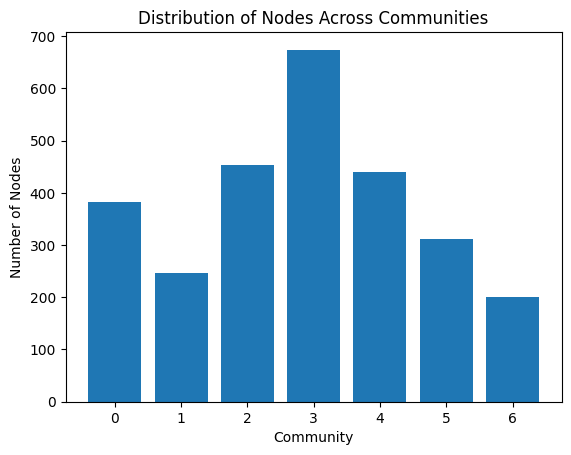

In [31]:
# Visualize community distribution
community_counts = [len(c) for c in communities]
plt.bar(range(len(community_counts)), community_counts)
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Nodes Across Communities')
plt.show()